<a href="https://colab.research.google.com/github/CamiloVga/Codes/blob/main/Clase_FineTuning_Clasificador_BaseStreaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers datasets scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-e085bbe2db62>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items

Step,Training Loss
5,0.013700
10,0.009500
15,0.003800
20,0.003900
25,0.002800
30,0.001900
35,0.002700


<ipython-input-28-e085bbe2db62>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-e085bbe2db62>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-e085bbe2db62>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-e085bbe2db62>:39: UserWarning: To copy construct fro

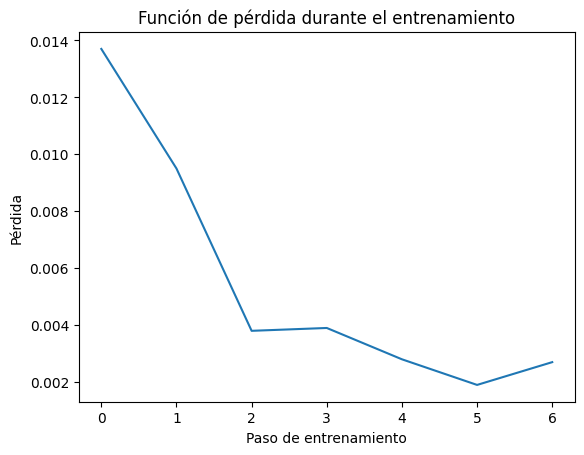

Entrenamiento completado y modelo guardado.


In [28]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Cargar el dataset
dataset = load_dataset("mteb/amazon_reviews_multi", "es", split="train", streaming=True)

# Tomar N muestras aleatorias
n=100
samples = []
for _ in range(n):
    samples.append(next(iter(dataset)))

# Extraer textos y etiquetas
texts = [sample['text'] for sample in samples]  # Clave corregida
labels = [sample['label'] for sample in samples]

# Codificar las etiquetas
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Cargar el tokenizer y el modelo
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenizar los textos
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Preparar el dataset de PyTorch
class AmazonReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

dataset = AmazonReviewsDataset(tokenized_inputs, encoded_labels)

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=5,  # Registrar la pérdida cada 5 pasos
    report_to="none"  # Desactivar reporting a herramientas externas como WandB
)

# Definir una función para registrar la pérdida durante el entrenamiento
class LossRecorder(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_loss = []

    def log(self, logs):
        # Registro de la pérdida
        if "loss" in logs:
            self.training_loss.append(logs["loss"])
        super().log(logs)

# Iniciar el entrenamiento
trainer = LossRecorder(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

# Guardar el modelo
trainer.save_model("./fine_tuned_bert_amazon_reviews")

# Verificar si la lista de pérdidas tiene valores
if len(trainer.training_loss) > 0:
    # Graficar la pérdida
    plt.plot(trainer.training_loss)
    plt.title('Función de pérdida durante el entrenamiento')
    plt.xlabel('Paso de entrenamiento')
    plt.ylabel('Pérdida')
    plt.show()
else:
    print("No se registraron valores de pérdida durante el entrenamiento.")

print("Entrenamiento completado y modelo guardado.")


In [29]:
# Asegurarse de que el modelo esté en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función de inferencia usando el modelo entrenado
def inferencia_nueva_entrada(prompt, model, tokenizer):
    # Tokenizar el prompt y mover los tensores al dispositivo correcto
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Realizar la inferencia
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtener las predicciones
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Decodificar la predicción (ajustar según el dataset usado)
    if predicted_class == 0:
        return "Etiqueta: Muy Negativa"
    elif predicted_class == 1:
        return "Etiqueta: Negativa"
    elif predicted_class == 2:
        return "Etiqueta: Neutra"
    elif predicted_class == 3:
        return "Etiqueta: Positiva"
    elif predicted_class == 4:
        return "Etiqueta: Muy Positiva"
    else:
        return "Etiqueta desconocida"

# Ejemplo de uso del módulo de inferencia después del entrenamiento
nuevo_prompt = "Me encanta es dispositivo"
resultado = inferencia_nueva_entrada(nuevo_prompt, model, tokenizer)
print(f"Resultado del modelo: {resultado}")



Resultado del modelo: Etiqueta: Muy Negativa
